In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from rkcompetition.utils.data_preprocessing import *

In [2]:
inner_actions, outer_actions, type_contract, train, sample, outer_actions_in_train = read_raw_data('../data/raw/')

inner_actions.event_date = pd.to_datetime(inner_actions.event_date)
outer_actions.event_date = pd.to_datetime(outer_actions.event_date)
outer_actions_in_train.event_date = pd.to_datetime(outer_actions_in_train.event_date)

# для анализа
train = train.loc[train.blocked >= 0]

c:\users\monset\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Изучаем логи

In [3]:
inner_actions

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах
...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ


В логах содержится внутренние ивенты. Информации не особо много, но стоит посмотреть на количество уникальных значений и их распределение

In [4]:
np.unique(inner_actions.contract_id).shape, np.unique(inner_actions.event_type).shape

((4311,), (83,))

In [5]:
pd.DataFrame(inner_actions.event_type.value_counts().rename('Количество событий'))

,Количество событий
Информер ВК. Показ,8001
Включение интернета на 20 минут,4092
Обращение в службу заботы о клиентах,2860
Гарантированный платеж за деньги,2679
Виртуальное бессмертие. Использование,757
...,...
Предложение расширенной гарантии на ТВ приставку,3
Чек лист выполненных работ при регистрации,3
Удаление ip-адреса,2
Футболка Ситилинк,1


Некоторые ивенты встречаются чаще других. Плюс есть схожие (например, подарок в лк) - возможно, стоит их объединить в один.

In [6]:
inner_actions['val'] = 1
pivot = pd.pivot_table(inner_actions, index = ['contract_id'], columns = 'event_type', values = 'val')

(array([1622., 1033.,  626.,  380.,  243.,  139.,   90.,   64.,   34.,
          24.,   20.,   11.,   10.,    7.,    4.,    4.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 16 Patch objects>)

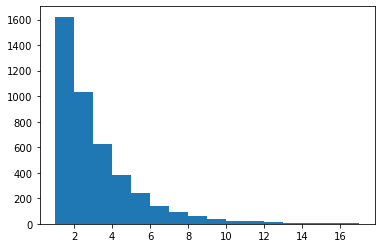

In [7]:
plt.hist(pivot.sum(axis = 1).sort_values(), bins = np.arange(1, 18))

Количество действий на пользователя быстро убывает

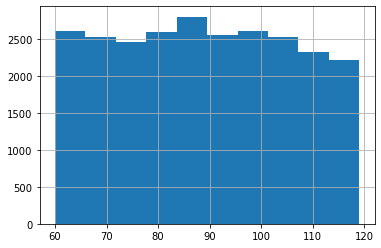

In [8]:
inner_actions.event_date.dt.day_of_year.hist()

Действия распределены равномерно

# изучаем обращение к конкурентам

In [9]:
outer_actions

,event_date,event_type,contract_id
0,2021-04-17,webmail.sampo.ru,101397
1,2021-04-17,webmail.sampo.ru,179624
2,2021-04-17,tvip-provision.sampo.ru,190335
3,2021-04-17,tvip-provision.sampo.ru,61670
4,2021-04-17,tvip-provision.sampo.ru,39370
...,...,...,...
10646530,2021-04-01,camera.rt.ru,186461
10646531,2021-04-01,camera.rt.ru,18785
10646534,2021-04-01,camera.rt.ru,67986
10646535,2021-04-01,camera.rt.ru,31576


In [10]:
outer_actions.event_date.sort_values()

9830192   2021-03-26
9705577   2021-03-26
9705573   2021-03-26
9705572   2021-03-26
9705571   2021-03-26
             ...    
7271361   2021-04-30
7271360   2021-04-30
7271359   2021-04-30
7271368   2021-04-30
836048    2021-04-30
Name: event_date, Length: 9393249, dtype: datetime64[ns]

Временной промежуток - 2 месяца

In [11]:
np.unique(outer_actions.contract_id).shape, np.unique(outer_actions.event_type).shape

((196115,), (195,))

Намного больше данных и пользователей указано при обращении к внешним источникам

In [12]:
pd.DataFrame(outer_actions.event_type.value_counts().rename('Количество событий'))

,Количество событий
camera.rt.ru,7333195
vmxott.svc.iptv.rt.ru,289876
tvip-provision.sampo.ru,138944
webmail.sampo.ru,132718
statserv.sampo.ru,110428
...,...
karelkniga.sampo.ru,2
id.rt.ru,2
chelyabinsk.rt.ru,2
igmar.sampo.ru,1


Много запросов к прямому конкуренту - sampo.ru

# Распределение целевого признака

In [13]:
train

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
5987,274601,1
5988,274710,1
5989,274782,1
5990,274786,1


Таблица представляет из себя лишь значения контракта и факт ухода / нет. Не особо много информации

In [14]:
train.blocked.value_counts()

0    5294
1     698
Name: blocked, dtype: int64

Text(0.5, 1.0, 'Распределение целевого класса')

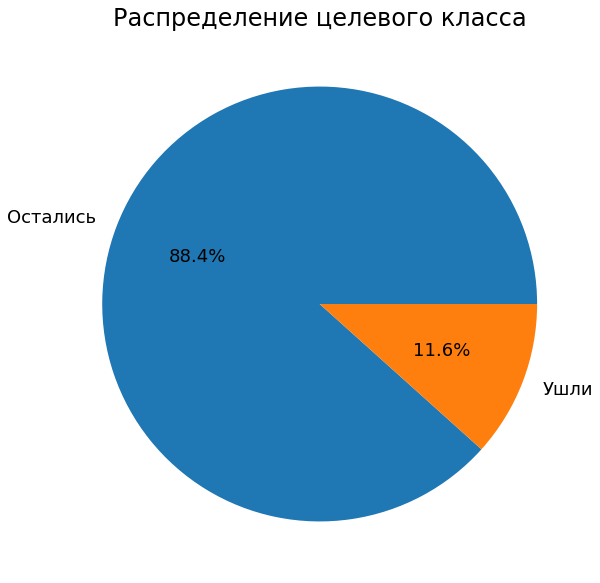

In [15]:
plt.figure(figsize = (10, 10))
pie_chart_data = pd.DataFrame(train.blocked.value_counts()).reset_index()
pie_chart_data.columns = ['Ушел', 'blocked']
pie_chart_data['Ушел'] = ['Остались', 'Ушли']
plt.pie(x = pie_chart_data['blocked'], labels = pie_chart_data['Ушел'], autopct='%1.1f%%', textprops={'fontsize': 18})
plt.title('Распределение целевого класса', fontsize = 24)

Дисбаланс в пользу оставшихся. Посмотрим пользователей, по кому совсем нет данных

In [16]:
train_with_inner_actions = train.loc[train.contract_id.isin(inner_actions.contract_id)].contract_id
len(train_with_inner_actions)

3809

In [17]:
train_with_outer_actions = train.loc[train.contract_id.isin(outer_actions.contract_id)].contract_id
len(train_with_outer_actions)

2882

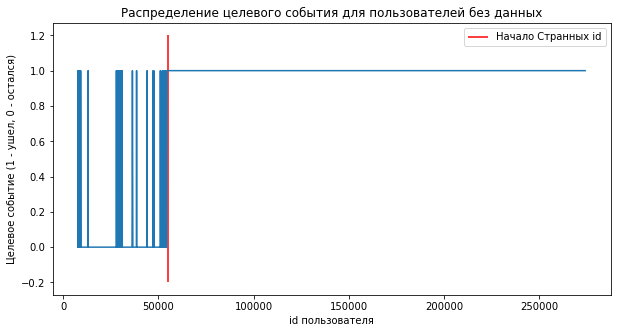

In [18]:
no_data = train.loc[~train.contract_id.isin(set(train_with_inner_actions).union(set(train_with_outer_actions)))] 

plt.figure(figsize = (10, 5))
plt.title('Распределение целевого события для пользователей без данных')
plt.vlines(55e3, -0.2, 1.2, colors = 'red', label = 'Начало Странных id')
plt.xlabel('id пользователя')
plt.ylabel('Целевое событие (1 - ушел, 0 - остался)')
plt.legend(loc = 'upper right')
plt.plot(no_data.contract_id, no_data.blocked)

Странное распределение - после 60 тысячного айдишника Начинаются одни положительные классы. Возможно, ошибка в данных

Text(0.5, 1.0, 'Распределение наличия данных у пользователей')

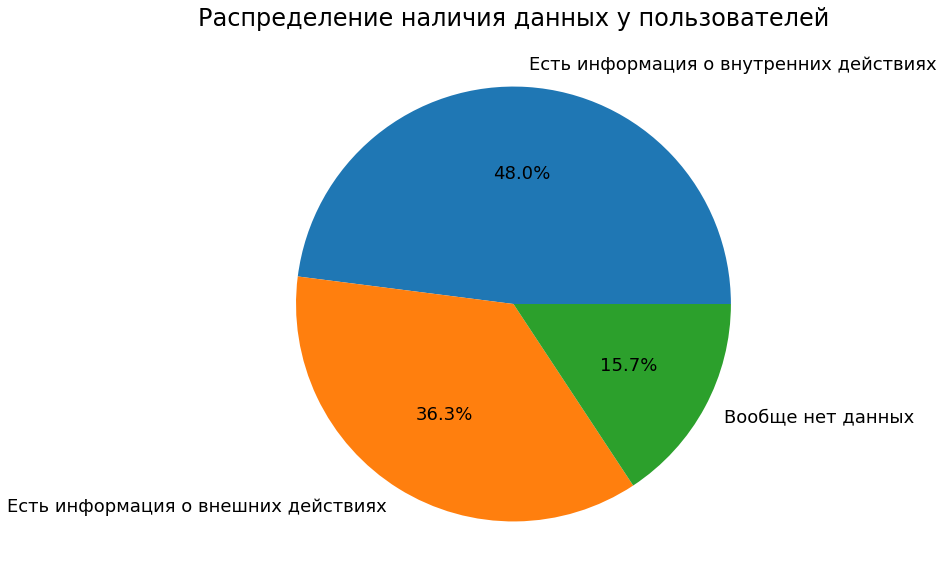

In [19]:
plt.figure(figsize = (10, 10))
data = [train_with_inner_actions.shape[0], train_with_outer_actions.shape[0], no_data.shape[0]]
labels = ['Есть информация о внутренних действиях', 'Есть информация о внешних действиях', 'Вообще нет данных']
plt.pie(x = data, labels = labels, autopct='%1.1f%%', textprops={'fontsize': 18})
plt.title('Распределение наличия данных у пользователей', fontsize = 24)

In [20]:
no_data.blocked.value_counts()

0    1109
1     139
Name: blocked, dtype: int64

In [21]:
no_data.loc[no_data.contract_id > 6e4].blocked.value_counts()

1    111
Name: blocked, dtype: int64

Может очень сильно повлиять на результат работы. Тем более, что на 1250 человек совсем нет никаких данных - и как с ними работать?

Странности с contract_id

In [22]:
train.corr()

,contract_id,blocked
contract_id,1.000000,0.794684
blocked,0.794684,1.000000


Из-за проблем с айдишниками есть ложная корреляция

Смотрим на тестовую

In [23]:
sample.contract_id.sort_values()

0      3453
1      3454
2      3455
3      3456
4      3457
       ... 
805    4258
806    4259
807    4260
808    4261
809    4262
Name: contract_id, Length: 810, dtype: int64

Все данные из тестовой выборки идут до данных с тренировочной выборки. Надеюсь, что проблема их не зацепила

type_contract

In [24]:
type_contract

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1
...,...,...
6800,3503,1
6801,3589,0
6802,4261,0
6803,4118,1


Ничего особенного - тип контракта

In [25]:
type_contract.day_or_month_contract.value_counts()

0    4022
1    2783
Name: day_or_month_contract, dtype: int64

Почти даже и равномерно распределены

In [26]:
type_contract.loc[type_contract.contract_id.isin(train.contract_id)]

,contract_id,day_or_month_contract
0,7780,0
2,7785,0
3,7794,0
4,7795,1
5,7798,0
...,...,...
6693,274601,1
6694,274710,0
6695,274782,0
6696,274786,1


Почти для всех есть это значение

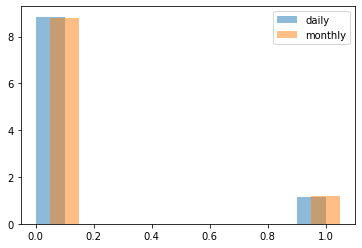

In [27]:
contract_with_train = type_contract.merge(train, how = 'left', on = 'contract_id')
plt.hist(contract_with_train.loc[contract_with_train.day_or_month_contract == 0].blocked, label = 'daily', density = True, alpha = 0.5)
plt.hist(contract_with_train.loc[contract_with_train.day_or_month_contract == 1].blocked, align = 'right',
         label = 'monthly', density = True, alpha = 0.5)
plt.legend(loc = 'upper right')

Распределения ушедших одинаково почти

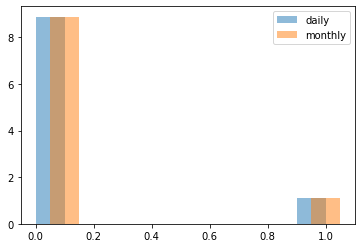

In [28]:
contract_with_train = type_contract.merge(train, how = 'left', on = 'contract_id')
contract_with_train = contract_with_train.loc[contract_with_train.contract_id.isin(no_data.contract_id)]
plt.hist(contract_with_train.loc[contract_with_train.day_or_month_contract == 0].blocked, label = 'daily', density = True, alpha = 0.5)
plt.hist(contract_with_train.loc[contract_with_train.day_or_month_contract == 1].blocked, align = 'right',
         label = 'monthly', density = True, alpha = 0.5)
plt.legend(loc = 'upper right')

Для пользователей без информации ситуация критична - различий нет в принципе.

# test data

In [29]:
sample

,contract_id,blocked
0,3453,-1
1,3454,-1
2,3455,-1
3,3456,-1
4,3457,-1
...,...,...
805,4258,-1
806,4259,-1
807,4260,-1
808,4261,-1


In [30]:
sum(sample.contract_id.isin(inner_actions.contract_id)), sum(sample.contract_id.isin(outer_actions.contract_id))

(502, 390)

In [31]:
len(set(sample.loc[sample.contract_id.isin(inner_actions.contract_id)].contract_id).union(set(sample.loc[sample.contract_id.isin(outer_actions.contract_id)].contract_id)))

652

У 150 пользователей из теста нет никакой информации по логам или конкурентам. Так же не удастстя их предсказать по типу контракта. Кошмар.

# Train

# named for train

In [32]:
outer_actions.loc[outer_actions.contract_id.isin(train.contract_id.values)]

,event_date,event_type,contract_id
61,2021-04-17,moigorod.sampo.ru,27891
62,2021-04-17,moigorod.sampo.ru,27891
63,2021-04-17,profile.sampo.ru,27891
64,2021-04-17,profile.sampo.ru,27891
65,2021-04-17,ohrana.sampo.ru,27891
...,...,...,...
10645464,2021-03-31,sz-mrsk-itv01.svc.iptv.rt.ru,31215
10645836,2021-03-31,numbers.cloudpbx.rt.ru,49479
10646087,2021-03-31,petrozavodsk.speedtest.rt.ru,14456
10646100,2021-03-31,petrozavodsk.speedtest.rt.ru,46919


In [33]:
outer_actions_in_train = outer_actions_in_train.merge(train, on = 'contract_id')
outer_actions_in_train['day_of_year'] = outer_actions_in_train.event_date.dt.day_of_year
outer_actions_in_train

,event_date,event_type,contract_id,blocked,day_of_year
0,2021-04-17,moigorod.sampo.ru,27891,0,107
1,2021-04-17,moigorod.sampo.ru,27891,0,107
2,2021-04-17,profile.sampo.ru,27891,0,107
3,2021-04-17,profile.sampo.ru,27891,0,107
4,2021-04-17,ohrana.sampo.ru,27891,0,107
...,...,...,...,...,...
123746,2021-03-31,rt-static.rt.ru,49248,0,90
123747,2021-03-31,fnc.rt.ru,161029,1,90
123748,2021-03-31,fnc.rt.ru,161029,1,90
123749,2021-03-31,wink.rt.ru,14720,0,90


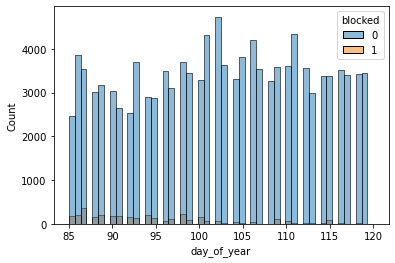

In [34]:
sns.histplot(data = outer_actions_in_train, x = 'day_of_year', hue = 'blocked')

В начале двух месяцев активность ушедших пользователей была намного выше

In [35]:
outer_actions.loc[outer_actions.contract_id.isin(sample.contract_id)].event_date.sort_values(ascending = False)

7245691   2021-04-29
826531    2021-04-29
825234    2021-04-29
825235    2021-04-29
825236    2021-04-29
             ...    
9815116   2021-03-26
9813133   2021-03-26
9813132   2021-03-26
9813131   2021-03-26
1144142   2021-03-26
Name: event_date, Length: 15172, dtype: datetime64[ns]

Хотя бы период дат совпадает

In [36]:
# среднее число откликов по ушедшим и нет

(outer_actions_in_train.loc[outer_actions_in_train.blocked == 0].shape, 
 outer_actions_in_train.loc[outer_actions_in_train.blocked == 1].shape)

((120322, 5), (3429, 5))

Окей, неушедших, очевидно, больше по кликам

# Вывод

Очень странные данные. Для 10 - 15 % пользователей нет данных в принципе и как для них что-то предсказывать - неясно. Наибольшую ценность может представлять информация о логах и обращениям к внешним ресурсам, но количество данных слишком велико к количеству пользователей, поэтому стоит использовать какие-то методы объединения сущностей.